In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import os,cmocean
import scipy.io as sio
import importlib
import bathy_helpers as bh
from scipy import interpolate
from pyproj import Proj
from bathy_helpers import *
from bathy_readers import *
from matplotlib import path

In [2]:
# Load bathy, and the t and f grid
bathyd1 = getnemo('/home/mdunphy/MEOPAR/NEMO-forcing/grid/bathy_downonegrid2.nc',     fillmissing=True)
bathy6  = getnemo('/home/mdunphy/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea6.nc', fillmissing=True)

cnc = nc.Dataset('/home/mdunphy/MEOPAR/NEMO-forcing/grid/coordinates_seagrid_SalishSea.nc', 'r')
glamf = cnc.variables['glamf'][0,...]; gphif = cnc.variables['gphif'][0,...]
glamt = cnc.variables['glamt'][0,...]; gphit = cnc.variables['gphit'][0,...]
cnc.close()
NY, NX = glamt.shape[0], glamt.shape[1]
glamfe, gphife = expandf(glamf, gphif)

In [3]:
cascadiafile = '/home/mdunphy/MEOPAR/Bathy/Cascadia/cascadia.bil'
cache=cascadiafile+".results.npz"
if os.path.exists(cache):
    npzfile = np.load(cache)
    locals().update(npzfile)
else:
    # Work with Cascadia data
    x,y,z,p = getcascadia(cascadiafile)

    # Convert NEMO coords to Cascadia projected coordinates
    Xt, Yt = p(glamt, gphit)
    Xf, Yf = p(glamf, gphif)
    Xfe, Yfe = p(glamfe, gphife)

    # There are too many points, so we filter based on minimum and maximum x,y
    idx1 = (x >= np.min(Xfe)) & (x <= np.max(Xfe))
    idx2 = (y >= np.min(Yfe)) & (y <= np.max(Yfe))
    x,y = x[idx1], y[idx2]
    z = z[idx2,:]
    z = z[:,idx1]
    X,Y = np.meshgrid(x, y, sparse=False, indexing='xy')
    X,Y,z = X.flatten(), Y.flatten(), z.flatten()

    # Further filter points not within the SalishSea domain
    poly0 = path.Path(makebox(Xfe,Yfe,0,NX,0,NY), closed=True)
    tmp = np.zeros([X.size,2]); tmp[:,0]=X; tmp[:,1]=Y;
    idx = poly0.contains_points(tmp)
    X, Y, z = X[idx], Y[idx], z[idx]

    # Construct new bathy using interpolation
    points = (X,Y)
    xi = (Xt.flatten(), Yt.flatten())
    casnearest = np.reshape(interpolate.griddata(points, z, xi, method='nearest'), Xt.shape)
    caslinear = np.reshape(interpolate.griddata(points, z, xi, method='linear'), Xt.shape)

    Xo,Yo = X-125,Y-125
    points = (Xo,Yo)
    casnearestjp = np.reshape(interpolate.griddata(points, z, xi, method='nearest'), Xt.shape)
    
    # Get the bin indices, apply bin methods
    boxi, boxj = getboxij(Xfe,Yfe,X,Y,cache=cascadiafile+".boxij.npz",searchmore=False)
    casmin,casmax,casmean,casmedian,cascount = binstobathy(boxi,boxj,X,Y,z,NX,NY)

    np.savez(cache, casmin=casmin, casmax=casmax, casmean=casmean, casmedian=casmedian,
                    cascount=cascount, casnearest=casnearest, caslinear=caslinear, casnearestjp=casnearestjp)
#1239279 points in 407.3525502681732 s
#hit0 report: 466518/1239279=37.644307698266495%
#hit1 report: 768443/1239279=62.00726390102632%
#hit2 report: 0/1239279=0.0%
#hit3 report: 0/1239279=0.0%
#hit4 report: 0/1239279=0.0%
#no hit report: 4318/1239279=0.3484284007071854%
#points not in domain: 0

In [4]:
chsfile = '/home/mdunphy/MEOPAR/Bathy/CHS/Salish Sea 25m Grid.txt'
cache=chsfile+".results.npz"
if os.path.exists(cache):
    npzfile = np.load(cache)
    locals().update(npzfile)
else:
    # Work with CHS data
    x,y,z,p=getchs(chsfile)

    # Convert NEMO coords to UTM Zone 10 coordinates
    Xt, Yt = p(glamt, gphit)
    Xf, Yf = p(glamf, gphif)
    Xfe, Yfe = p(glamfe, gphife)

    # Construct new bathy using interpolation
    points = (x,y)
    xi = (Xt.flatten(), Yt.flatten())
    chsnearest = np.reshape(interpolate.griddata(points, z, xi, method='nearest'), Xt.shape)
    chslinear = np.reshape(interpolate.griddata(points, z, xi, method='linear'), Xt.shape)

    # Get the bin indices, apply bin methods
    boxi, boxj = getboxij(Xfe,Yfe,x,y,cache=chsfile+".boxij.npz",searchmore=True)
    chsmin,chsmax,chsmean,chsmedian,chscount = binstobathy(boxi,boxj,x,y,z,NX,NY)
    cache=chsfile+".results.npz"
    np.savez(cache, chsmin=chsmin, chsmax=chsmax, chsmean=chsmean, chsmedian=chsmedian,
                    chscount=chscount, chsnearest=chsnearest, chslinear=chslinear)

In [5]:
bc3file = '/home/mdunphy/MEOPAR/Bathy/BC3/british_columbia_3sec.asc'
cache=bc3file+".results.npz"
if os.path.exists(cache):
    npzfile = np.load(cache)
    locals().update(npzfile)
else:
    # Work with BC3 data
    x,y,z,p = getbc3(bc3file)

    # There are too many points, so we filter based on minimum and maximum x,y
    idx1 = (x >= np.min(glamfe)) & (x <= np.max(glamfe))
    idx2 = (y >= np.min(gphife)) & (y <= np.max(gphife))
    x,y = x[idx1], y[idx2]
    z = z[idx2,:]
    z = z[:,idx1]
    X,Y = np.meshgrid(x, y, sparse=False, indexing='xy')
    X,Y,z = X.flatten(), Y.flatten(), z.flatten()

    # Further filter points not within the SalishSea domain
    poly0 = path.Path(makebox(glamfe,gphife,0,NX,0,NY), closed=True)
    tmp = np.zeros([X.size,2]); tmp[:,0]=X; tmp[:,1]=Y;
    idx = poly0.contains_points(tmp)
    X, Y, z = X[idx], Y[idx], z[idx]

    # Construct new bathy using interpolation
    points = (X,Y)
    xi = (glamt.flatten(), gphit.flatten())
    bc3nearest = np.reshape(interpolate.griddata(points, z, xi, method='nearest'), glamt.shape)
    bc3linear = np.reshape(interpolate.griddata(points, z, xi, method='linear'), glamt.shape)

    # Get the bin indices, apply bin methods
    boxi, boxj = getboxij(glamfe,gphife,X,Y,cache=bc3file+".boxij.npz",searchmore=False)   # takes 15-20 mins
    bc3min,bc3max,bc3mean,bc3median,bc3count = binstobathy(boxi,boxj,X,Y,z,NX,NY)

    np.savez(cache, bc3min=bc3min, bc3max=bc3max, bc3mean=bc3mean, bc3median=bc3median,
                    bc3count=bc3count, bc3nearest=bc3nearest, bc3linear=bc3linear)
#10309989 points in 1063.4851875305176 s
#hit0 report: 8509929/10309989=82.54062152733626%
#hit1 report: 1790466/10309989=17.366323087250628%
#hit2 report: 0/10309989=0.0%
#hit3 report: 0/10309989=0.0%
#hit4 report: 0/10309989=0.0%
#no hit report: 9594/10309989=0.09305538541311732%
#points not in domain: 0

In [6]:
cache = "/home/mdunphy/MEOPAR/Bathy/mdbathy_jan12.npz"
if os.path.exists(cache):
    npzfile = np.load(cache)
    locals().update(npzfile)
else:
    importlib.reload(bh)

    # Synthesize a new bathy by a weighted sum
    # I put chs weight to zero because it should be already included in BC3 (of course we can revisit this...)
    md0 = bh.bathyblend(casmean, chsmean, bc3mean, 1, 0, 10)

    # Clip depth of water points to [3,428]
    md1 = np.copy(md0)
    #md1[(md1 > 0) & (md1 < 1)] = 0
    md1[(md1 > 0) & (md1 < 3)] = 3
    md1[md1 > 428] = 428

    # More processing following JP
    mdCL = bh.lakefill(  bh.channelfill(md1)  ) # MDCL = Fill channels and then fill lakes
    mdL  = bh.lakefill(  md1                  ) # MDL = Fill lakes only

    np.savez(cache, md0=md0, md1=md1, mdL=mdL, mdCL=mdCL)

<IPython.core.display.Javascript object>


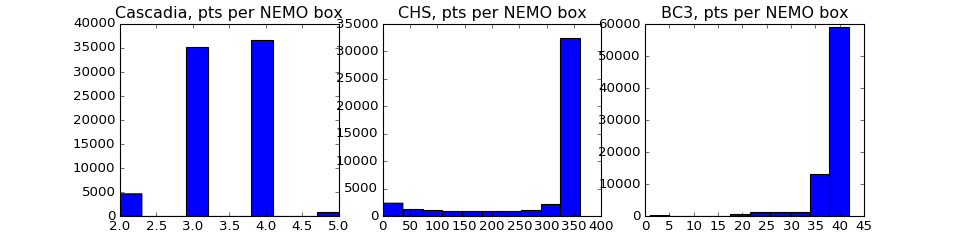

In [7]:
def dezero(x): return x.flatten()[x.flatten()>0]
plt.figure(figsize=(12,3)); plt.clf();
plt.subplot(1,3,1); plt.hist(dezero(cascount)); plt.title('Cascadia, pts per NEMO box')
plt.subplot(1,3,2); plt.hist(dezero(chscount)); plt.title('CHS, pts per NEMO box')
plt.subplot(1,3,3); plt.hist(dezero(bc3count)); plt.title('BC3, pts per NEMO box')

In [8]:
# Plotting helper funtions
def mm(x):
    return ma.masked_array(x, mask=(x == 0 | np.isnan(x)))

def cmp(a,b,c,d,e):  # compare a and b, mask from c, colorbar limits d, title e
    im=plt.pcolormesh(c*0 + a -b); cb=plt.colorbar(im);
    im.set_cmap('seismic'); im.set_clim([-d,d]); cb.set_clim(-d,d); plt.title(e)
def shw(a,b,c,d):  # plot a, mask b, colorbar limits c, title d
    if b is None: b=mm(a)
    im=plt.pcolormesh(b*0+a); cb=plt.colorbar(im);
    im.set_cmap(cmocean.cm.haline); im.set_clim([0,c]); cb.set_clim(0,c); plt.title(d)

# Same except for Frasher river mouth zoom
imin = 350; imax = 505; jmin = 280; jmax = 398
islice = slice(imin,imax); jslice = slice(jmin, jmax)
def sl(x):
    if x is not None: return x[islice,jslice]
def cmpz(a,b,c,d,e):  # compare a and b, mask from c, colorbar limits d, title e
    cmp(sl(a), sl(b), sl(c), d, e)
def shwz(a,b,c,d):  # plot a, mask b, colorbar limits c, title d
    shw(sl(a), sl(b), c, d)


<IPython.core.display.Javascript object>


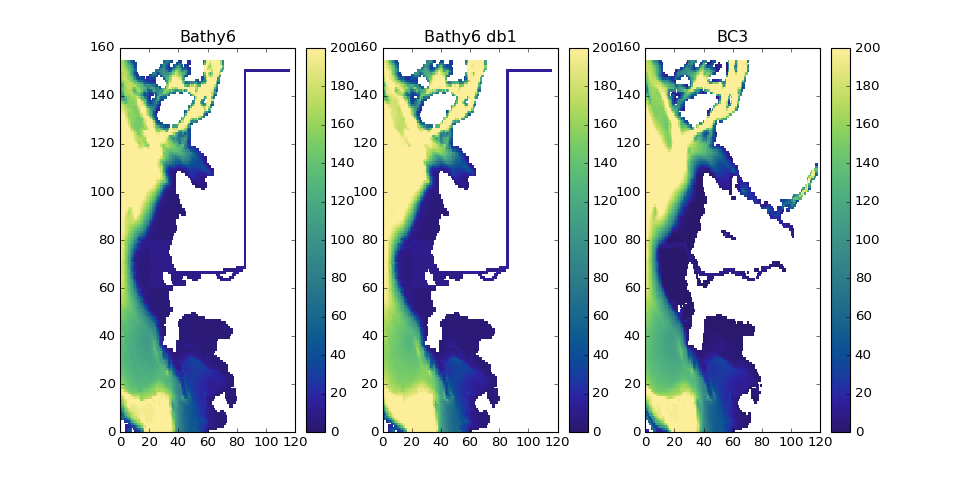

In [9]:
# Zoom in on Fraser river mouth, show new BC3 strategy
plt.figure(figsize=(12,6)); plt.clf();
plt.subplot(1,3,1); shwz(bathy6, None, 200, 'Bathy6')
plt.subplot(1,3,2); shwz(bathyd1, None, 200, 'Bathy6 db1')
plt.subplot(1,3,3); shwz(bc3mean, None, 200, 'BC3')

<IPython.core.display.Javascript object>


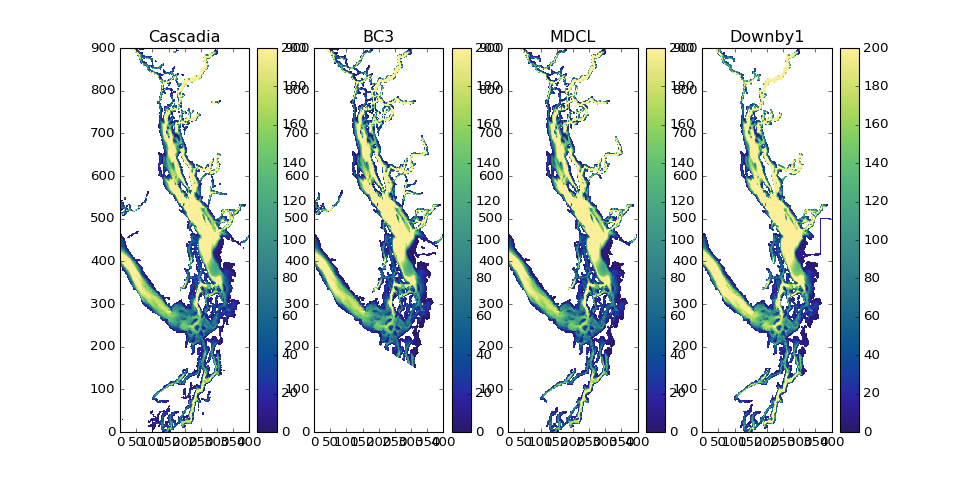

In [10]:
# Compare the result with the two source bathys and Downby1
plt.figure(figsize=(12,6)); plt.clf();
plt.subplot(1,4,1); shw(casmean, None, 200, 'Cascadia')
plt.subplot(1,4,2); shw(bc3mean, None, 200, 'BC3')
plt.subplot(1,4,3); shw(mdCL, None, 200, 'MDCL')
plt.subplot(1,4,4); shw(bathyd1, None, 200, 'Downby1')


<IPython.core.display.Javascript object>


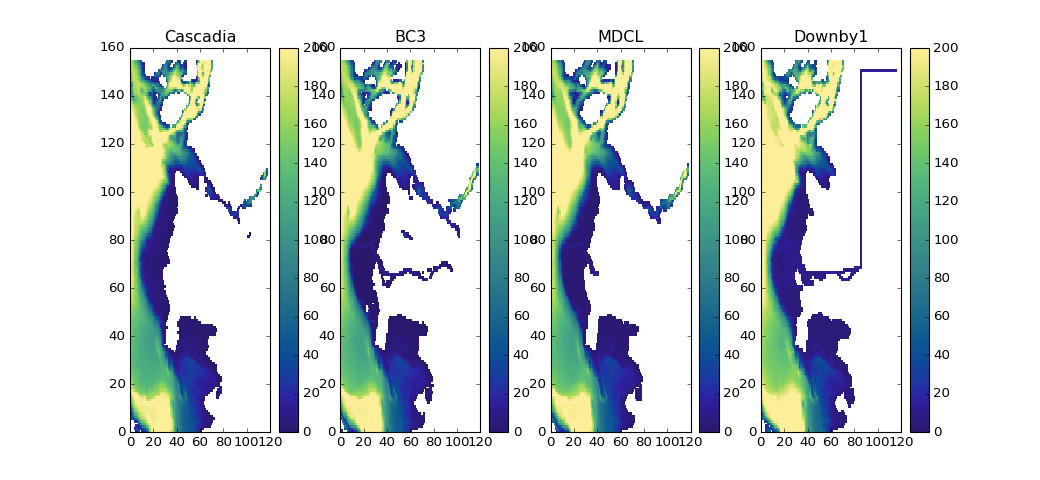

In [11]:
# Same as before but zoom on Fraser river mouth
plt.figure(figsize=(13,6)); plt.clf();
plt.subplot(1,4,1); shwz(casmean, None, 200, 'Cascadia')
plt.subplot(1,4,2); shwz(bc3mean, None, 200, 'BC3')
plt.subplot(1,4,3); shwz(mdCL, None, 200, 'MDCL')
plt.subplot(1,4,4); shwz(bathyd1, None, 200, 'Downby1')

<IPython.core.display.Javascript object>


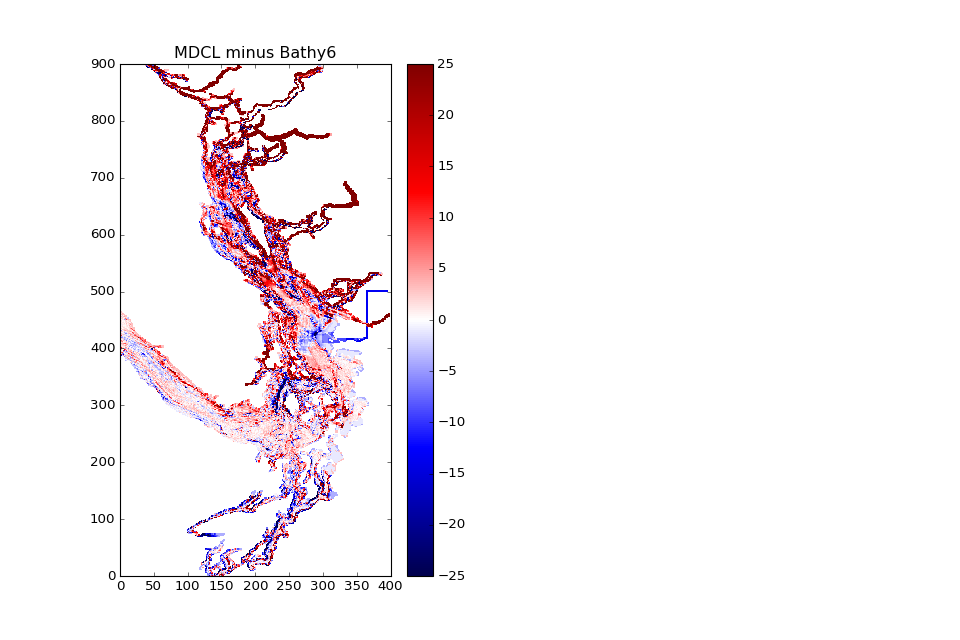

In [12]:
# Rough measure of the adjustment 
plt.figure(figsize=(12,8)); plt.clf();
plt.subplot(1,2,1); cmp(mdCL, bathy6, mm(mdCL+bathy6), 25, 'MDCL minus Bathy6')

<IPython.core.display.Javascript object>


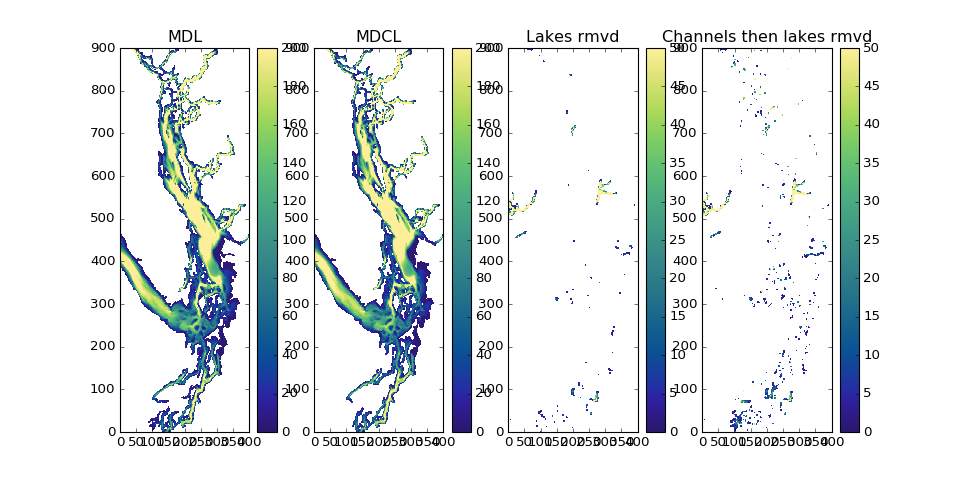

In [13]:
# Show the action of the lake and channel remover
plt.figure(figsize=(12,6)); plt.clf();
plt.subplot(1,4,1); shw(mdL, None, 200, 'MDL')
plt.subplot(1,4,2); shw(mdCL, None, 200, 'MDCL')
plt.subplot(1,4,3); shw(md1-mdL, None, 50, 'Lakes rmvd')
plt.subplot(1,4,4); shw(md1-mdCL, None, 50, 'Channels then lakes rmvd')

In [19]:
import scipy.io as sio
mfile = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
k, area, ncst = mfile['k'], mfile['Area'], mfile['ncst']

<IPython.core.display.Javascript object>


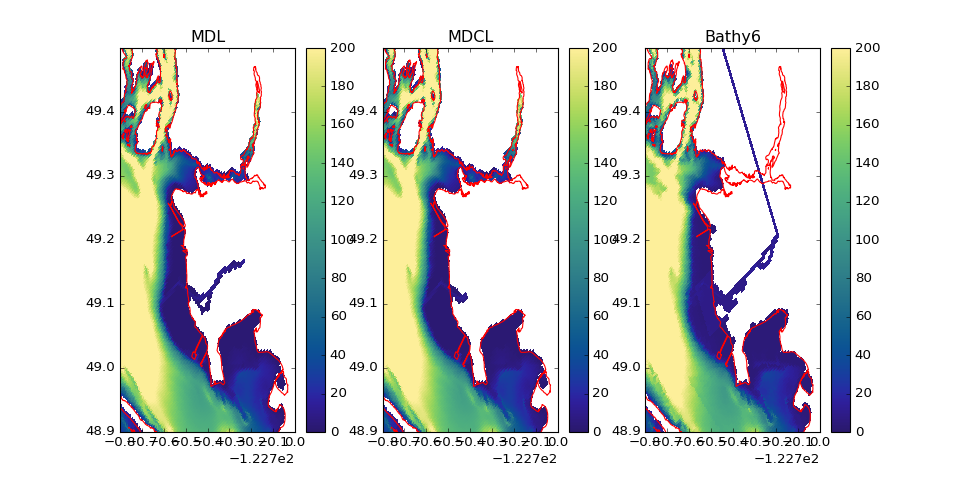

In [33]:
def shwll(x,y,a,b,c,d):  # plot a, mask b, colorbar limits c, title d
    if b is None: b=mm(a)
    im=plt.pcolormesh(x,y,b*0+a); cb=plt.colorbar(im);
    im.set_cmap(cmocean.cm.haline); im.set_clim([0,c]); cb.set_clim(0,c); plt.title(d)
    plt.plot(ncst[:,0],ncst[:,1],'r')
    plt.gca().set_xlim(-123.5,-122.7)
    plt.gca().set_ylim(48.9,49.5)

plt.figure(figsize=(12,6)); plt.clf();
plt.subplot(1,3,1); shwll(glamt,gphit,bathy6, None, 200, 'Bathy6')
plt.subplot(1,3,1); shwll(glamt,gphit,mdL, None, 200, 'MDL')
plt.subplot(1,3,2); shwll(glamt,gphit,mdCL, None, 200, 'MDCL')
